In [1]:
import sys
sys.path.insert(0, '/tf/pollock')

In [2]:
import logging
import os
import random
from collections import Counter
from importlib import reload


import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory
import pollock.models.analysis as pollock_analysis

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [3]:
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

## gpu stuff

In [ ]:
# from importlib import reload
# reload(pollock)
# reload(pollock.models.model)

In [ ]:
# from tensorflow.python.client import device_lib
# import tensorflow as tf
# device_lib.list_local_devices()

In [ ]:
# tf.config.list_physical_devices('XLA_GPU')

In [ ]:
# tf.keras.backend.clear_session()
# tf.config.optimizer.set_jit(True)

In [ ]:
# mirrored_strategy = tf.distribute.MirroredStrategy(
#     devices=["/device:XLA_GPU:0"])

In [ ]:
# pollock.models.model.set_training_devices(['/device:XLA_GPU:0'])

## load in expression table and labels

In [5]:
DATA_DIR = '/home/estorrs/data/single_cell_classification'
MODEL_DIR = '/home/estorrs/pollock/models'

In [6]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

#### set filepaths and parameters

###### scRNAseq benchmark

In [6]:
run_name = 'allen_mouse_brain_class'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Filtered_mouse_allen_brain_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'Class'

n_per_cell_type = 2000
epochs = 5
batch_size = 64

In [34]:
run_name = 'allen_mouse_brain_subclass'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Filtered_mouse_allen_brain_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'Subclass'

n_per_cell_type = 2000
epochs = 5
batch_size = 64

In [73]:
run_name = 'allen_mouse_brain_cluster'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Filtered_mouse_allen_brain_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'AMB', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'cluster'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [203]:
run_name = 'cell_bench_10x_5cl'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'CellBench', '10x_5cl', '10x_5cl_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'CellBench', '10x_5cl', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'cell_bench_10x_CelSeq2_5cl'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'CellBench', 'CelSeq2_5cl', '10x_CelSeq2_5cl_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'CellBench', 'CelSeq2_5cl', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [6]:
run_name = 'pancreatic_baron_human_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Baron Human', 'Filtered_Baron_HumanPancreas_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Baron Human', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 2000
epochs = 5
batch_size = 64

In [230]:
run_name = 'pancreatic_baron_mouse_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Baron Mouse', 'Filtered_MousePancreas_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Baron Mouse', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [243]:
run_name = 'pancreatic_muraro_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Muraro', 'Filtered_Muraro_HumanPancreas_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Muraro', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [257]:
run_name = 'pancreatic_segerstolpe_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Segerstolpe', 'Filtered_Segerstolpe_HumanPancreas_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Segerstolpe', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [271]:
run_name = 'pancreatic_xin_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Xin', 'Filtered_Xin_HumanPancreas_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Pancreatic_data', 'Xin', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [6]:
run_name = 'tm_filtered'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'TM', 'Filtered_TM_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'TM', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [9]:
run_name = 'zheng_68k_unsorted'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng 68K', 'Filtered_68K_PBMC_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng 68K', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 10000
epochs = 5
batch_size = 64

In [25]:
run_name = 'zheng_sorted'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng sorted', 'Filtered_DownSampled_SortedPBMC_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Intra-dataset',
                             'Zheng sorted', 'Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_10x-v2'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv2', '10Xv2_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv2', '10Xv2_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [42]:
run_name = 'pbmc_bench_10x-v3'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', '10Xv3', '10Xv3_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_CEL-Seq'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'CEL-Seq', 'CL_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'CEL-Seq', 'CL_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_Drop-Seq'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Drop-Seq', 'DR_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Drop-Seq', 'DR_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_inDrop'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'inDrop', 'iD_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'inDrop', 'iD_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_SCINA'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'SCINA data', 'SCINA_data.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'SCINA data', 'SCINA_Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [ ]:
run_name = 'pbmc_bench_Seq-Well'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Seq-Well', 'SW_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Seq-Well', 'SW_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

In [67]:
run_name = 'pbmc_bench_Smart-Seq2'

expression_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Smart-Seq2', 'SM2_pbmc1.csv')
label_fp = os.path.join(DATA_DIR, 'scRNAseq_benchmark', 'Inter-dataset',
                             'PbmcBench', 'Smart-Seq2', 'SM2_pbmc1Labels.csv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Unnamed: 0'
sep=','
cell_type_key = 'x'

n_per_cell_type = 1000
epochs = 5
batch_size = 64

###### ding lab tumor

In [85]:
run_name = 'hnsc_v0_0_1'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'HNSC', 'raw', 'hnsc_yize',
                            'Assigned_WUHN_15_processed_cluster_review_gene_expression_format_2.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'HNSC', 'raw', 'hnsc_yize',
                            'Assigned_WUHN_15_processed_cluster_review_cell_metadata_format_2.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 5
batch_size = 64

In [7]:
run_name = 'cesc_v0_0_1'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'CESC', 'raw', 'cesc_yize_v2',
                            'Assigned_CESC_9_processed_cluster_review_final_gene_expression_format.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'CESC', 'raw', 'cesc_yize_v2',
                            'Assigned_CESC_9_processed_cluster_review_final_cell_metadata_format.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 10
batch_size = 128

In [171]:
run_name = 'br'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 5
batch_size = 128

###### HCA

#### load in data

In [ ]:
#### scRNAseq benchmark

In [8]:
%%time
expression_df = pd.read_csv(
    expression_fp,
    sep=sep)
expression_df

CPU times: user 6min 47s, sys: 11.4 s, total: 6min 59s
Wall time: 6min 59s


,Genes,AAACCCATCTACAGGT-1_1,AAACGAAAGCAGGCAT-1_1,AAACGAACATGCTGCG-1_1,AAACGAATCTTGGAAC-1_1,AAACGCTAGACGCCAA-1_1,AAAGAACGTTTCGTTT-1_1,AAAGGATAGCGGACAT-1_1,AAAGGATAGTGGCGAT-1_1,AAAGGATCAATCCTTT-1_1,...,TTTGGTTTCTTGGTCC-1_9,TTTGTTGAGAATGTTG-1_9,TTTGTTGAGAATTTGG-1_9,TTTGTTGAGATTAGTG-1_9,TTTGTTGAGGTGCCTC-1_9,TTTGTTGCAATAACGA-1_9,TTTGTTGGTGAATGTA-1_9,TTTGTTGGTTACCCTC-1_9,TTTGTTGGTTTGCAGT-1_9,TTTGTTGTCATCGTAG-1_9
0,MIR1302-2HG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FAM138A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,OR4F5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AL627309.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AL627309.3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33746,HPV75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33747,HPV78,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33748,HPV-mCG2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33749,HPV-mCG3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
expression_df = expression_df.set_index(sample_column)
expression_df

,AAACCCATCTACAGGT-1_1,AAACGAAAGCAGGCAT-1_1,AAACGAACATGCTGCG-1_1,AAACGAATCTTGGAAC-1_1,AAACGCTAGACGCCAA-1_1,AAAGAACGTTTCGTTT-1_1,AAAGGATAGCGGACAT-1_1,AAAGGATAGTGGCGAT-1_1,AAAGGATCAATCCTTT-1_1,AAAGGATGTGCGAGTA-1_1,...,TTTGGTTTCTTGGTCC-1_9,TTTGTTGAGAATGTTG-1_9,TTTGTTGAGAATTTGG-1_9,TTTGTTGAGATTAGTG-1_9,TTTGTTGAGGTGCCTC-1_9,TTTGTTGCAATAACGA-1_9,TTTGTTGGTGAATGTA-1_9,TTTGTTGGTTACCCTC-1_9,TTTGTTGGTTTGCAGT-1_9,TTTGTTGTCATCGTAG-1_9
Genes,,,,,,,,,,,,,,,,,,,,,
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HPV75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HPV78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HPV-mCG2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
expression_df = expression_df.transpose()
expression_df

Genes,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,HPV70,HPV71,HPV76,HPV77,HPV74,HPV75,HPV78,HPV-mCG2,HPV-mCG3,MCV
AAACCCATCTACAGGT-1_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGAAAGCAGGCAT-1_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGAACATGCTGCG-1_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGAATCTTGGAAC-1_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGCTAGACGCCAA-1_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAATAACGA-1_9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGTTGGTGAATGTA-1_9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGTTGGTTACCCTC-1_9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGTTGGTTTGCAGT-1_9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [163]:
expression_df.to_hdf(expression_fp.replace('.tsv', '.h5'), 'df')

In [11]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df

,cell_id,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
0,AAACCCAAGACCGTTT-1_8,Assigned_507_1,CESC,epithelial,cervix,CESC_Malignant/Epithelial_4,human,sc,no
1,AAACCCAAGCAGGCTA-1_9,Assigned_574_1,CESC,epithelial,cervix,CESC_Malignant/Epithelial_2,human,sc,no
2,AAACCCAAGCCTATCA-1_8,Assigned_507_1,CESC,epithelial,cervix,Fibroblast,human,sc,no
3,AAACCCAAGCGATCGA-1_2,Assigned_468_1,CESC,epithelial,cervix,CD8+T,human,sc,no
4,AAACCCAAGCGGTATG-1_7,Assigned_470_3,CESC,epithelial,cervix,Fibroblast,human,sc,no
...,...,...,...,...,...,...,...,...,...
31740,TTTGTTGTCCACATAG-1_6,Assigned_470_2,CESC,epithelial,cervix,CESC_Malignant/Epithelial_1,human,sc,no
31741,TTTGTTGTCCGGCAGT-1_5,Assigned_470_1,CESC,epithelial,cervix,CESC_Malignant/Epithelial_1,human,sc,no
31742,TTTGTTGTCCGTATAG-1_5,Assigned_470_1,CESC,epithelial,cervix,CESC_Malignant/Epithelial_1,human,sc,no
31743,TTTGTTGTCGGTAGGA-1_7,Assigned_470_3,CESC,epithelial,cervix,CESC_Malignant/Epithelial_1,human,sc,no


In [12]:
label_df = label_df.set_index('cell_id')
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
cell_id,,,,,,,,
AAACCCAAGACCGTTT-1_8,Assigned_507_1,CESC,epithelial,cervix,CESC_Malignant/Epithelial_4,human,sc,no
AAACCCAAGCAGGCTA-1_9,Assigned_574_1,CESC,epithelial,cervix,CESC_Malignant/Epithelial_2,human,sc,no
AAACCCAAGCCTATCA-1_8,Assigned_507_1,CESC,epithelial,cervix,Fibroblast,human,sc,no
AAACCCAAGCGATCGA-1_2,Assigned_468_1,CESC,epithelial,cervix,CD8+T,human,sc,no
AAACCCAAGCGGTATG-1_7,Assigned_470_3,CESC,epithelial,cervix,Fibroblast,human,sc,no
...,...,...,...,...,...,...,...,...
TTTGTTGTCCACATAG-1_6,Assigned_470_2,CESC,epithelial,cervix,CESC_Malignant/Epithelial_1,human,sc,no
TTTGTTGTCCGGCAGT-1_5,Assigned_470_1,CESC,epithelial,cervix,CESC_Malignant/Epithelial_1,human,sc,no
TTTGTTGTCCGTATAG-1_5,Assigned_470_1,CESC,epithelial,cervix,CESC_Malignant/Epithelial_1,human,sc,no


In [13]:
label_df = label_df.loc[expression_df.index]
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
AAACCCATCTACAGGT-1_1,Assigned_321_1,CESC,epithelial,cervix,Macrophage/Monocyte,human,sc,no
AAACGAAAGCAGGCAT-1_1,Assigned_321_1,CESC,epithelial,cervix,Macrophage/Monocyte,human,sc,no
AAACGAACATGCTGCG-1_1,Assigned_321_1,CESC,epithelial,cervix,Fibroblast,human,sc,no
AAACGAATCTTGGAAC-1_1,Assigned_321_1,CESC,epithelial,cervix,Fibroblast,human,sc,no
AAACGCTAGACGCCAA-1_1,Assigned_321_1,CESC,epithelial,cervix,Fibroblast,human,sc,no
...,...,...,...,...,...,...,...,...
TTTGTTGCAATAACGA-1_9,Assigned_574_1,CESC,epithelial,cervix,Fibroblast,human,sc,no
TTTGTTGGTGAATGTA-1_9,Assigned_574_1,CESC,epithelial,cervix,Macrophage/Monocyte,human,sc,no
TTTGTTGGTTACCCTC-1_9,Assigned_574_1,CESC,epithelial,cervix,CESC_Malignant/Epithelial_2,human,sc,no
TTTGTTGGTTTGCAGT-1_9,Assigned_574_1,CESC,epithelial,cervix,NK,human,sc,no


In [14]:
## just make sure we match index locations
np.count_nonzero(label_df.index == expression_df.index)

31745

In [15]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

AnnData object with n_obs × n_vars = 31745 × 33751 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [16]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('CESC_Malignant/Epithelial_1', 10983),
 ('CESC_Malignant/Epithelial_2', 5471),
 ('CESC_Malignant/Epithelial_4', 3436),
 ('CD8+T', 2522),
 ('Fibroblast', 2202),
 ('Macrophage/Monocyte', 1926),
 ('NK', 1352),
 ('Plasma', 1165),
 ('CD4+T', 1113),
 ('Endothelial', 731),
 ('CESC_Malignant/Epithelial_3', 435),
 ('Monocyte', 201),
 ('Mast', 137),
 ('Erythrocyte', 67),
 ('Epithelial', 4)]

In [434]:
adata.X.nbytes

5377519764

In [38]:
## remove cell types with less than 5 cells
cell_types_to_remove = [c for c, count in counts.most_common() if count < 5]
mask = np.asarray([True if c not in cell_types_to_remove else False
       for c in adata.obs[cell_type_key]])
adata = adata[mask]

In [39]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('L6 IT', 1848),
 ('Sst', 1600),
 ('Vip', 1554),
 ('L4', 1348),
 ('Pvalb', 1266),
 ('Lamp5', 1067),
 ('L2/3 IT', 973),
 ('L6 CT', 953),
 ('L5 IT', 836),
 ('L5 PT', 539),
 ('L6b', 343),
 ('NP', 314),
 ('Sncg', 123),
 ('Serpinf1', 25),
 ('Astro', 11),
 ('VLMC', 11),
 ('Meis2', 8),
 ('Oligo', 5),
 ('Endo', 5)]

In [17]:
## remove unknown
adata = adata[adata.obs[cell_type_key]!='Unknown']
adata

View of AnnData object with n_obs × n_vars = 31745 × 33751 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [18]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('CESC_Malignant/Epithelial_1', 10983),
 ('CESC_Malignant/Epithelial_2', 5471),
 ('CESC_Malignant/Epithelial_4', 3436),
 ('CD8+T', 2522),
 ('Fibroblast', 2202),
 ('Macrophage/Monocyte', 1926),
 ('NK', 1352),
 ('Plasma', 1165),
 ('CD4+T', 1113),
 ('Endothelial', 731),
 ('CESC_Malignant/Epithelial_3', 435),
 ('Monocyte', 201),
 ('Mast', 137),
 ('Erythrocyte', 67),
 ('Epithelial', 4)]

#### filtering if needed

In [356]:
Counter(adata.obs[cell_type_key]).most_common()

[('CD8+ Cytotoxic T', 20307),
 ('CD8+/CD45RA+ Naive Cytotoxic', 16361),
 ('CD56+ NK', 8522),
 ('CD4+/CD25 T Reg', 6116),
 ('CD19+ B', 5579),
 ('CD4+/CD45RO+ Memory', 3031),
 ('Dendritic', 1946),
 ('CD14+ Monocyte', 1944),
 ('CD4+/CD45RA+/CD25- Naive T', 1857),
 ('CD34+', 188),
 ('CD4+ T Helper2', 92)]

In [16]:
## filter smartly
cell_type_to_idxs = {}
for cell_id, cell_type in zip(adata.obs.index, adata.obs[cell_type_key]):
    if cell_type not in cell_type_to_idxs:
        cell_type_to_idxs[cell_type] = [cell_id]
    else:
        cell_type_to_idxs[cell_type].append(cell_id)
        
def temp(ls):
    if len(ls) > 100:
        return random.sample(ls, 100)
    return ls

cell_type_to_idxs = {k:temp(ls)
                     for k, ls in cell_type_to_idxs.items()}

idxs = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
filtered = adata[idxs]

In [17]:
Counter(filtered.obs[cell_type_key]).most_common()

[('CD8+ Cytotoxic T', 100),
 ('CD8+/CD45RA+ Naive Cytotoxic', 100),
 ('CD4+/CD45RO+ Memory', 100),
 ('CD19+ B', 100),
 ('CD4+/CD25 T Reg', 100),
 ('CD56+ NK', 100),
 ('CD4+/CD45RA+/CD25- Naive T', 100),
 ('CD34+', 100),
 ('Dendritic', 100),
 ('CD14+ Monocyte', 100),
 ('CD4+ T Helper2', 92)]

In [ ]:
adata.var

In [ ]:
# sc.tl.rank_genes_groups(adata, 'x', n_genes=100)

In [ ]:
# sc.pl.rank_genes_groups(adata)

In [191]:
sc.pp.scale(filtered)

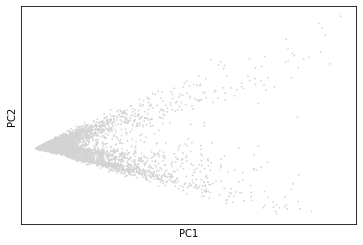

In [192]:
sc.tl.pca(filtered, svd_solver='arpack')
sc.pl.pca(filtered)

In [193]:
sc.pp.neighbors(filtered, n_neighbors=15)

/home/estorrs/miniconda3/envs/pollock/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/pollock/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


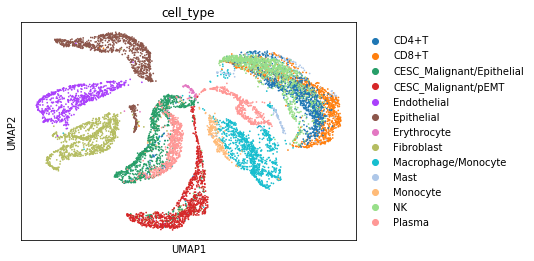

In [194]:
sc.tl.umap(filtered)
sc.pl.umap(filtered, color=cell_type_key, edges=False)

In [ ]:
# sc.pp.neighbors(adata, n_neighbors=15)

In [ ]:
# g_template, c_template = pollock.models.model.create_block_image_template(
#         adata, key='x', block_shape=(4, 4), size=(128, 128), nn_threshold=.05)
# g_template, c_template

In [ ]:
# sorted(set(c_template.flatten()))

In [ ]:
# plt.imshow(c_template=='')

## train pollock model

In [12]:
# cell_labels = pollock_dataset.adata[pollock_dataset.train_cell_ids].obs[cell_type_key]
# counts = Counter(cell_labels)
# cell_type_to_weight = {c: (1 / count) * len(cell_labels) / len(counts)
#         for c, count in counts.items()}
# cell_type_to_weight

In [15]:
np.repeat([[1,2,3]], 5, axis=0)

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [19]:
%%time
# pollock_dataset = pollock.models.model.PollockDataset(filtered, cell_type_key=cell_type_key, dataset_type='training',
#                                 image_root_dir=training_image_dir, batch_size=batch_size,
#                                 n_per_cell_type=5000, max_val_per_cell_type=10000,
#                                 block_shape=(8,8), template_shape=(128, 128),
#                                 template_generation_max_per_cell=100)
pollock_dataset = pollock.models.model.PollockDataset(adata, cell_type_key=cell_type_key, dataset_type='training',
                                image_root_dir=training_image_dir, batch_size=batch_size,
                                n_per_cell_type=1000, max_val_per_cell_type=10000,
                                block_shape=(8,8), template_shape=(128, 128),
                                template_generation_max_per_cell=100)

2020-02-21 17:05:59,676 creating image templates
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cancer_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'tissue_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'organ_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'species' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'method' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'facs' as categorical
/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_gene

CPU times: user 4min 52s, sys: 2min 31s, total: 7min 24s
Wall time: 3min 2s


In [20]:
x,y = next(iter(pollock_dataset.train_ds))
x.shape, y.shape

(TensorShape([128, 128, 128, 3]), TensorShape([128, 15]))

(1, 33751) (33751,)


/tf/pollock/pollock/models/model.py:524: RuntimeWarning: divide by zero encountered in log2
  expression = np.log2(X[i])


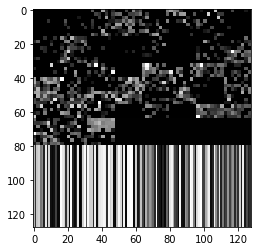

In [37]:
cell_id = adata.obs.index[2]

img = pollock_dataset.get_cell_images([cell_id])

In [38]:
adata.obs.iloc[2]

sample_id      Assigned_321_1
cancer_type              CESC
tissue_type        epithelial
organ_type             cervix
cell_type          Fibroblast
species                 human
method                     sc
facs                       no
Name: AAACGAACATGCTGCG-1_1, dtype: object

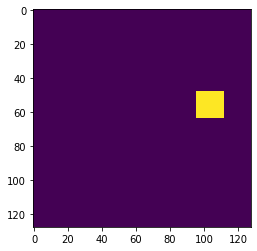

In [40]:
plt.imshow(pollock_dataset.cell_type_template=='Epithelial_diff_Fibroblast')

In [22]:
# from IPython.display import Image
# Image(filename='/models/scratch/zheng_68k_unsorted/training/0640838a-0984-4794-8175-4eb1494baa44/AAATCTGACTTATC-7_13.jpg') 

In [23]:
pollock_dataset.cell_types, sorted(set(pollock_dataset.cell_type_template.flatten()))

(['CD4+T',
  'CD8+T',
  'CESC_Malignant/Epithelial_1',
  'CESC_Malignant/Epithelial_2',
  'CESC_Malignant/Epithelial_3',
  'CESC_Malignant/Epithelial_4',
  'Endothelial',
  'Epithelial',
  'Erythrocyte',
  'Fibroblast',
  'Macrophage/Monocyte',
  'Mast',
  'Monocyte',
  'NK',
  'Plasma'],
 ['',
  'CD4+T',
  'CD4+T_diff_CD8+T',
  'CD4+T_diff_CESC_Malignant/Epithelial_1',
  'CD4+T_diff_Mast',
  'CD4+T_diff_NK',
  'CD8+T',
  'CD8+T_diff_Endothelial',
  'CD8+T_diff_Epithelial',
  'CD8+T_diff_Mast',
  'CD8+T_diff_NK',
  'CESC_Malignant/Epithelial_1',
  'CESC_Malignant/Epithelial_1_diff_CESC_Malignant/Epithelial_2',
  'CESC_Malignant/Epithelial_1_diff_Epithelial',
  'CESC_Malignant/Epithelial_2',
  'CESC_Malignant/Epithelial_3',
  'CESC_Malignant/Epithelial_3_diff_Epithelial',
  'CESC_Malignant/Epithelial_4',
  'CESC_Malignant/Epithelial_4_diff_Epithelial',
  'Endothelial',
  'Endothelial_diff_Epithelial',
  'Endothelial_diff_Fibroblast',
  'Endothelial_diff_Mast',
  'Epithelial',
  'Epithel

In [24]:
# plt.imshow(pollock_dataset.cell_type_template=='CESC_Malignant/Epithelial_diff_CESC_Malignant/pEMT')

In [74]:
model = PollockModel(pollock_dataset.cell_types, img_height=pollock_dataset.template_shape[0],
                     img_width=pollock_dataset.template_shape[1], learning_rate=.0005,
                     model=None)
# model = PollockModel(pollock_dataset.cell_types, model='resnet50')

In [75]:
model.model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16384)            

In [76]:
# with tf.device('/device:XLA_GPU:0'):

model.fit(pollock_dataset, epochs=20, batch_size=batch_size, balance_classes=True)

Train for 199 steps, validate for 50 steps
Epoch 1/20
199/199 [==============================] - 6s 30ms/step - loss: 0.5098 - accuracy: 0.8443 - val_loss: 0.1120 - val_accuracy: 0.9630
Epoch 2/20
199/199 [==============================] - 5s 27ms/step - loss: 0.1440 - accuracy: 0.9547 - val_loss: 0.0747 - val_accuracy: 0.9747
Epoch 3/20
199/199 [==============================] - 7s 35ms/step - loss: 0.1073 - accuracy: 0.9667 - val_loss: 0.0699 - val_accuracy: 0.9747
Epoch 4/20
199/199 [==============================] - 6s 28ms/step - loss: 0.0901 - accuracy: 0.9722 - val_loss: 0.0636 - val_accuracy: 0.9775
Epoch 5/20
199/199 [==============================] - 5s 26ms/step - loss: 0.0783 - accuracy: 0.9752 - val_loss: 0.0594 - val_accuracy: 0.9789
Epoch 6/20
199/199 [==============================] - 7s 33ms/step - loss: 0.0649 - accuracy: 0.9795 - val_loss: 0.0648 - val_accuracy: 0.9794
Epoch 7/20
199/199 [==============================] - 6s 28ms/step - loss: 0.0612 - accuracy: 0.980

2020-02-21 19:42:44,907 Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

In [28]:
%%time
cell_ids = sorted(set(pollock_dataset.train_cell_ids))

X_train = pollock_dataset.get_cell_images(cell_ids, show=False)

mask = np.asarray([True if c in set(cell_ids) else False
                   for c in pollock_dataset.adata.obs.index])
y_train = np.asarray(pollock_dataset.adata.obs[mask].loc[cell_ids][cell_type_key])

X_train.shape, y_train.shape

(25388, 33751) (33751,)


/tf/pollock/pollock/models/model.py:524: RuntimeWarning: divide by zero encountered in log2
  expression = np.log2(X[i])


CPU times: user 3min 58s, sys: 16 s, total: 4min 14s
Wall time: 3min 33s


((25388, 128, 128, 3), (25388,))

In [29]:
%%time
cell_ids = sorted(set(pollock_dataset.val_cell_ids))

X_val = pollock_dataset.get_cell_images(cell_ids, show=False)

mask = np.asarray([True if c in set(cell_ids) else False
                   for c in pollock_dataset.adata.obs.index])
y_val = np.asarray(pollock_dataset.adata.obs[mask].loc[cell_ids][cell_type_key])
X_val.shape, y_val.shape

(6357, 33751) (33751,)


/tf/pollock/pollock/models/model.py:524: RuntimeWarning: divide by zero encountered in log2
  expression = np.log2(X[i])


CPU times: user 55.5 s, sys: 8.27 s, total: 1min 3s
Wall time: 49.2 s


((6357, 128, 128, 3), (6357,))

In [30]:
metadata = {
    'dataset': {
        'name': run_name,
        'total_cells': adata.shape[0],
        'cell_types': pollock_dataset.cell_types,
        'cell_counts': counts.most_common(),
    },
    'model_training': {
        'training_pool_size_per_cell_type': n_per_cell_type,
        'validation_size': pollock_dataset.val_length,
        'training_size': pollock_dataset.train_length,
        'epochs': epochs,
        'train_cell_ids': pollock_dataset.train_cell_ids,
        'val_cell_ids': pollock_dataset.val_cell_ids,
        'batch_size': batch_size
    }
}

In [31]:
model.save(pollock_dataset, model_save_dir,
          X_val=X_val, y_val=y_val, X_train=X_train, y_train=y_train, metadata=metadata)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [353]:
import json
d = json.load(open(model_save_dir + '/summary.json'))

In [354]:
d.keys()

dict_keys(['dataset', 'model_training', 'history', 'validation', 'training'])

In [134]:
prediction_dataset, model = load_from_directory(adata, model_save_dir,
        image_root_dir=os.path.join('/home/estorrs/pollock/models', 'scratch', 'test_prediction'))

2020-02-17 11:33:11,733 writing images
2020-02-17 11:33:14,085 0 cell images written
/home/estorrs/pollock/pollock/models/model.py:242: RuntimeWarning: divide by zero encountered in log2
  expression = np.log2(X[i])
2020-02-17 11:33:16,515 1000 cell images written
2020-02-17 11:33:18,989 2000 cell images written
2020-02-17 11:33:21,412 3000 cell images written
2020-02-17 11:33:23,838 4000 cell images written
2020-02-17 11:33:26,263 5000 cell images written
2020-02-17 11:33:28,698 6000 cell images written
2020-02-17 11:33:31,129 7000 cell images written
2020-02-17 11:33:33,554 8000 cell images written
2020-02-17 11:33:35,977 9000 cell images written
2020-02-17 11:33:38,397 10000 cell images written
2020-02-17 11:33:40,819 11000 cell images written
2020-02-17 11:33:43,240 12000 cell images written
2020-02-17 11:33:45,264 done writing images


Found 12829 images belonging to 1 classes.


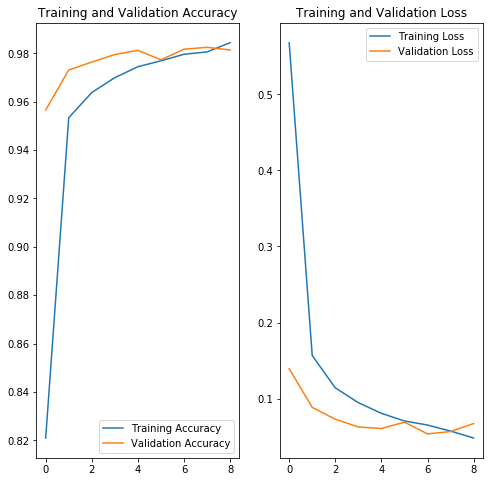

In [41]:
pollock_analysis.show_history(model.history)

In [178]:
%%time
# prediction_dataset, model = load_from_directory(adata, '/home/estorrs/pollock/models/abm_3class',
#         image_root_dir = '/home/estorrs/pollock/models/scratch/test_amb_prediction')

# prediction_dataset, model = load_from_directory(adata, '/home/estorrs/pollock/models/zheng_68k_unfiltered',
#         image_root_dir = '/home/estorrs/pollock/models/scratch/test_zheng_68k_unfiltered_prediction')

CPU times: user 28 µs, sys: 7 µs, total: 35 µs
Wall time: 69.6 µs


In [340]:
# # probs = model.predict(prediction_dataset)
# probs = model.predict(prediction_dataset.prediction_ds)

# probs.shape

In [77]:
# probs = model.predict(prediction_dataset)
probs = model.predict(X_val)

probs.shape

(6357, 15)

In [84]:
probs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [78]:
predictions = np.argmax(probs, axis=1).flatten()
max_prob = np.asarray([np.max(x) for x in probs])
predicted_labels = [pollock_dataset.cell_types[i] for i in predictions]
len(predictions), predictions[:5]

(6357, array([5, 9, 2, 5, 2]))

In [79]:
# cell_type_to_index = {v:k for k, v in enumerate(prediction_dataset.cell_types)}
# groundtruth = [cell_type_to_index[cell_type]
#                for cell_type in adata[prediction_dataset.cell_ids, :].obs['x']]

cell_type_to_index = {v:k for k, v in enumerate(pollock_dataset.cell_types)}
groundtruth = [cell_type_to_index[cell_type]
               for cell_type in y_val]
len(groundtruth), groundtruth[:5]

(6357, [5, 9, 2, 5, 2])

In [83]:
predictions, groundtruth = zip(*[(p, g) for p, g, prob in zip(predictions, groundtruth, max_prob)
                                if prob > .9999])
len(predictions), len(groundtruth)

(6357, 6357)

In [80]:
from sklearn.metrics import classification_report
report = classification_report(groundtruth, predictions, target_names=pollock_dataset.cell_types,
                               output_dict=True)
report

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'CD4+T': {'precision': 0.9095022624434389,
  'recall': 0.9013452914798207,
  'f1-score': 0.9054054054054054,
  'support': 223},
 'CD8+T': {'precision': 0.9620758483033932,
  'recall': 0.9544554455445544,
  'f1-score': 0.9582504970178926,
  'support': 505},
 'CESC_Malignant/Epithelial_1': {'precision': 0.990493435943866,
  'recall': 0.9959035047792444,
  'f1-score': 0.9931911030413072,
  'support': 2197},
 'CESC_Malignant/Epithelial_2': {'precision': 0.9945155393053017,
  'recall': 0.993607305936073,
  'f1-score': 0.9940612151667428,
  'support': 1095},
 'CESC_Malignant/Epithelial_3': {'precision': 0.9882352941176471,
  'recall': 0.9655172413793104,
  'f1-score': 0.9767441860465116,
  'support': 87},
 'CESC_Malignant/Epithelial_4': {'precision': 0.9956584659913169,
  'recall': 1.0,
  'f1-score': 0.9978245105148659,
  'support': 688},
 'Endothelial': {'precision': 1.0,
  'recall': 0.9795918367346939,
  'f1-score': 0.9896907216494846,
  'support': 147},
 'Epithelial': {'precision': 0.0,


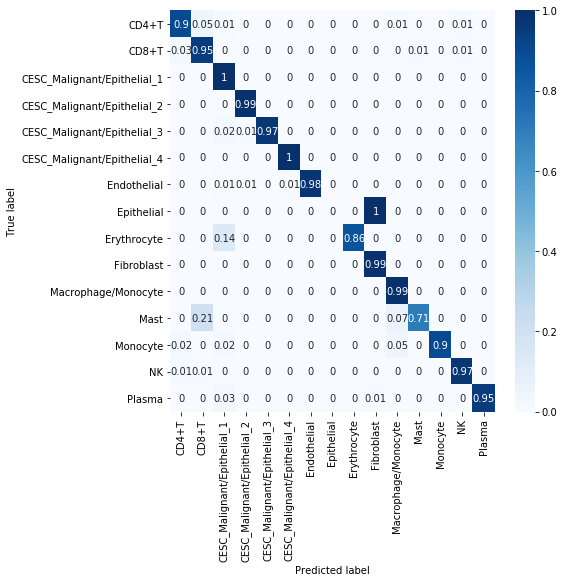

In [81]:
c_df = pollock_analysis.get_confusion_matrix(predictions, groundtruth, pollock_dataset.cell_types)

In [53]:
Counter(predicted_labels).most_common()

[('CESC_Malignant/Epithelial_1', 2215),
 ('CESC_Malignant/Epithelial_2', 1097),
 ('CESC_Malignant/Epithelial_4', 689),
 ('CD8+T', 511),
 ('Fibroblast', 440),
 ('Macrophage/Monocyte', 374),
 ('NK', 288),
 ('Plasma', 222),
 ('CD4+T', 212),
 ('Endothelial', 142),
 ('CESC_Malignant/Epithelial_3', 88),
 ('Monocyte', 45),
 ('Mast', 20),
 ('Erythrocyte', 14)]

In [208]:
(y_val=='CESC_Malignant/Epithelial') & (np.asarray(predicted_labels)=='CESC_Malignant/pEMT')




1084

In [214]:
import tensorflow as tf
list_ds = tf.data.Dataset.list_files(str(training_image_dir + '/validation' + '/*/*'))

In [228]:
[fp.numpy().decode('utf-8').split(os.path.sep)[-1].replace('.jpg', '') for fp in list(list_ds)]

['ACCAAACCAACAACAA-1_9',
 'GCCAGGTTCTCATGGA-1_9',
 'TCTCACGAGACGATAT-1_8',
 'TAGGTTGAGAGGGTGG-1_8',
 'TGCATCCAGGTACAGC-1_9',
 'TAGACCAGTCTACAGT-1_9',
 'TGAATCGTCTACGCAA-1_8',
 'GTTATGGAGTTGTAAG-1_9',
 'TGTAGACTCTTCGATT-1_8',
 'TGCAGTAGTCTGGTTA-1_9',
 'TTCTTCCTCGGCCTTT-1_9',
 'TCGAAGTGTACAATAG-1_7',
 'GATCAGTAGGCATCTT-1_9',
 'TCCCATGAGATGCTAA-1_9',
 'AGGGTTTAGTTTCAGC-1_9',
 'TGCTTCGGTCGTACTA-1_9',
 'TCATACTTCACCGACG-1_7',
 'TGTCCCACATCAGTGT-1_8',
 'TGAGGTTCAGTTACCA-1_7',
 'TATCTGTTCCTACACC-1_9',
 'GCATCTCCACAAGCTT-1_9',
 'TTCAGGATCCGATTAG-1_9',
 'GTAGTACAGGTAAACT-1_9',
 'TTCATTGCAGGTGGAT-1_7',
 'CATAAGCAGCTGTCCG-1_4',
 'TGAGCGCTCACGGAGA-1_9',
 'TGCGGCAAGTAATCCC-1_9',
 'TTGACCCCAGAGATTA-1_9',
 'GAGAGGTTCGCTAAAC-1_9',
 'GGTGAAGGTTCCCACT-1_9',
 'TGTAGACTCCTAAGTG-1_8',
 'GGGACCTTCCATTCAT-1_7',
 'TAGGTTGCACGAAGAC-1_9',
 'TGTTGAGGTCAACCTA-1_8',
 'GTCAAACGTGATTAGA-1_9',
 'TGTTGAGTCGTGACTA-1_7',
 'TTGCATTGTGTCATCA-1_7',
 'TTTACCAGTGGCTGCT-1_9',
 'TGATCTTGTTGGCTAT-1_8',
 'TTTGTTGGTAATGCGG-1_7',


In [202]:
predicted_labels

['CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/pEMT',
 'Fibroblast',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/pEMT',
 'Fibroblast',
 'Fibroblast',
 'Epithelial',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'Macrophage/Monocyte',
 'CD4+T',
 'Plasma',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/Epithelial',
 'Fibroblast',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/Epithelial',
 'NK',
 'CESC_Malignant/pEMT',
 'CD4+T',
 'NK',
 'Epithelial',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'NK',
 'CESC_Malignant/pEMT',
 'Fibroblast',
 'NK',
 'CESC_Malignant/Epithelial',
 'CESC_Malignant/pEMT',
 'Fibroblast',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/Epithelial',
 'CD4+T',
 'CESC_Malignant/pEMT',
 'CESC_Malignant/pE

In [65]:
embedding = pollock_analysis.umap_final_layer(X_val, model)
embedding.shape

(3941, 2)

... storing 'predicted_cell_type' as categorical
... storing 'groundtruth_cell_type' as categorical


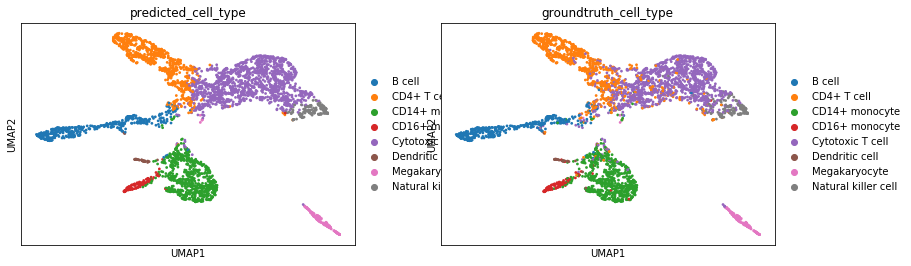

In [66]:
ordered_adata = anndata.AnnData(X=np.full((len(y_val), len(y_val)), 1.))
ordered_adata.obsm['X_umap'] = embedding
ordered_adata.obs['predicted_cell_type'] = predicted_labels
ordered_adata.obs['groundtruth_cell_type'] = y_val
sc.pl.umap(ordered_adata, color=['predicted_cell_type', 'groundtruth_cell_type'])

In [136]:
ordered_adata = adata[y_val, :]
ordered_adata.obsm['X_umap'] = embedding
ordered_adata.obs['predicted_cell_type'] = predicted_labels
sc.pl.umap(ordered_adata, color=['predicted_cell_type', cell_type_key])

KeyError: "Values ['HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Plasma', 'Endothelial', 'B', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Plasma', 'CD4+T', 'Plasma', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'CD4+T', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Mast', 'Plasma', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'CD4+T', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'B', 'Mast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'Plasma', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'Endothelial', 'Mast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'Plasma', 'Fibroblast', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'CD4+T', 'Plasma', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'B', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Plasma', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Mast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Endothelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Plasma', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'B', 'CD4+T', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Fibroblast', 'CD4+T', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'B', 'B', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Plasma', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'NK', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Fibroblast', 'Plasma', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Mast', 'CD4+T', 'B', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'B', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Plasma', 'B', 'NK', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Mast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'Endothelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'CD4+T', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD8+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Mast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Endothelial', 'Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'B', 'Fibroblast', 'B', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Plasma', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Fibroblast', 'NK', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'B', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Mast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'CD4+T', 'NK', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Macrophage/Monocyte', 'Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Plasma', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Plasma', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Monocyte', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'B', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'NK', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'NK', 'B', 'CD4+T', 'Mast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Endothelial', 'Mast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Plasma', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Mast', 'CD4+T', 'NK', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Mast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'B', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'Plasma', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Endothelial', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'B', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Plasma', 'Monocyte', 'CD4+T', 'NK', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Plasma', 'NK', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'B', 'NK', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'B', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Endothelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'B', 'Endothelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Mast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'CD4+T', 'Mast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Mast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'B', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Mast', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'Endothelial', 'Plasma', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'B', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Plasma', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'B', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'NK', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'Mast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'NK', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'NK', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Monocyte', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Plasma', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Mast', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'CD4+T', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'CD4+T', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial'], from ['HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Plasma', 'Endothelial', 'B', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Plasma', 'CD4+T', 'Plasma', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'CD4+T', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Mast', 'Plasma', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'CD4+T', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'B', 'Mast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'Plasma', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'Endothelial', 'Mast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'Plasma', 'Fibroblast', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'CD4+T', 'Plasma', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'B', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Plasma', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Mast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Endothelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Plasma', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'B', 'CD4+T', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Fibroblast', 'CD4+T', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'B', 'B', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Plasma', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'NK', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Fibroblast', 'Plasma', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Mast', 'CD4+T', 'B', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'B', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Plasma', 'B', 'NK', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Mast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'Endothelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'CD4+T', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD8+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Mast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Plasma', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Endothelial', 'Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'B', 'Fibroblast', 'B', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Plasma', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Fibroblast', 'NK', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'B', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Mast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'CD4+T', 'NK', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Macrophage/Monocyte', 'Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Plasma', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Plasma', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Mast', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Plasma', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'B', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Plasma', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Monocyte', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'B', 'NK', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Monocyte', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'NK', 'Mast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'NK', 'B', 'CD4+T', 'Mast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Endothelial', 'Mast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Plasma', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Mast', 'CD4+T', 'NK', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Plasma', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Mast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'NK', 'B', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'Plasma', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Plasma', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Endothelial', 'NK', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Plasma', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'Plasma', 'B', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Plasma', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Mast', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Plasma', 'Monocyte', 'CD4+T', 'NK', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Plasma', 'NK', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'B', 'NK', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Plasma', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'B', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'Endothelial', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'B', 'Endothelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'Mast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'CD4+T', 'Mast', 'Monocyte', 'HNSC_Malignant/Epithelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Mast', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'B', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Plasma', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'B', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'Fibroblast', 'B', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Endothelial', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Mast', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'CD4+T', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'NK', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Plasma', 'Endothelial', 'Plasma', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'B', 'Endothelial', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Plasma', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Plasma', 'B', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'NK', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'B', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Mast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'B', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'CD4+T', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'Mast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'CD4+T', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Mast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Mast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'NK', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'NK', 'Fibroblast', 'B', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Endothelial', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'Mast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Mast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'B', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'CD4+T', 'Fibroblast', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'NK', 'NK', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'NK', 'CD4+T', 'Fibroblast', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'CD4+T', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'Plasma', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Endothelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'B', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'Endothelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'NK', 'NK', 'Endothelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'NK', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'NK', 'NK', 'NK', 'NK', 'CD4+T', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Plasma', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'B', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'Fibroblast', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'NK', 'Plasma', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Macrophage/Monocyte', 'Endothelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'Fibroblast', 'Endothelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Plasma', 'Fibroblast', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Mast', 'CD4+T', 'Fibroblast', 'Endothelial', 'NK', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'B', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'B', 'NK', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Macrophage/Monocyte', 'Plasma', 'Fibroblast', 'NK', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Plasma', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Endothelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Plasma', 'Macrophage/Monocyte', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Plasma', 'CD4+T', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'CD4+T', 'Endothelial', 'NK', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Monocyte', 'Plasma', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Plasma', 'Macrophage/Monocyte', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'B', 'Endothelial', 'Plasma', 'NK', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'Endothelial', 'Fibroblast', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'Endothelial', 'Fibroblast', 'Mast', 'Plasma', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'Macrophage/Monocyte', 'Plasma', 'Endothelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'NK', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'B', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Mast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Fibroblast', 'Endothelial', 'Endothelial', 'CD4+T', 'B', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'Fibroblast', 'Macrophage/Monocyte', 'NK', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'CD4+T', 'B', 'CD4+T', 'Endothelial', 'CD4+T', 'CD4+T', 'Fibroblast', 'NK', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'NK', 'NK', 'NK', 'Macrophage/Monocyte', 'NK', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'CD4+T', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'NK', 'Fibroblast', 'Endothelial', 'NK', 'HNSC_Malignant/Epithelial', 'Endothelial', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Mast', 'CD4+T', 'Fibroblast', 'B', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'CD4+T', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'CD4+T', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'NK', 'HNSC_Malignant/Epithelial', 'NK', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'B', 'Macrophage/Monocyte', 'CD4+T', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'CD4+T', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Macrophage/Monocyte', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Macrophage/Monocyte', 'HNSC_Malignant/Epithelial', 'NK', 'Fibroblast', 'HNSC_Malignant/Epithelial', 'Endothelial', 'HNSC_Malignant/Epithelial', 'HNSC_Malignant/Epithelial', 'Fibroblast', 'Endothelial', 'B', 'HNSC_Malignant/Epithelial'], are not valid obs/ var names or indices."